# Preliminary Arbitrage/Liquidation ABS for ETH Market

This script:
- Generates a random/reasonable borrower distribution
- Generates a GBM price curve for the collateral/USD price
- Runs an agent based simulation where a liquidator agent hard liquidates positions and arbitrages LLAMMA when doing so is profitable. We incorporate a naive external slippage curve to account for market impact on external spot exchanges (i.e. Uniswap).
- Outputs metrics related to the simulation:
    - System health
    - Hard liquidation PnL
    - Arbitrage PnL

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.llamma import LLAMMA
from src.controller import Controller
from src.oracle import Oracle
from src.mpolicy import MonetaryPolicy
from src.liquidator import Liquidator
import pandas as pd
import numpy as np
from datetime import datetime
from src.utils import _plot_borrowers, gen_gbm
import matplotlib.pyplot as plt
from src.utils import external_swap
import copy
import imageio
from src.utils import plot_sim

In [4]:
WINDOW = 600 # 10 minutes
BASE_PRICE = 1800
A = 100
FEE = 0.006
ADMIN_FEE = 1
LOAN_DISCOUNT = 0.09
LIQUIDATION_DISCOUNT = 0.06

N_BORROWERS = 100
VALUE = 60_000_000 # USD value of collateral
COINS = 60_000_000 / BASE_PRICE # Number of collateral coins
DEBT = 44_000_000 # crvUSD debt

TOLERANCE = 0 # Min profit for liquidator to act

# START = int(datetime.now().timestamp())
START = 1697675181

# For plotting/gifs
FPS = 3

oracle = Oracle(WINDOW)
oracle.update(START, BASE_PRICE) # set initial price
llamma = LLAMMA(A, BASE_PRICE, oracle, FEE, admin_fee=ADMIN_FEE)
mpolicy = MonetaryPolicy()
controller = Controller(llamma, mpolicy, LOAN_DISCOUNT, LIQUIDATION_DISCOUNT) 
liquidator = Liquidator(TOLERANCE, verbose=True)

## Generate borrower distribution

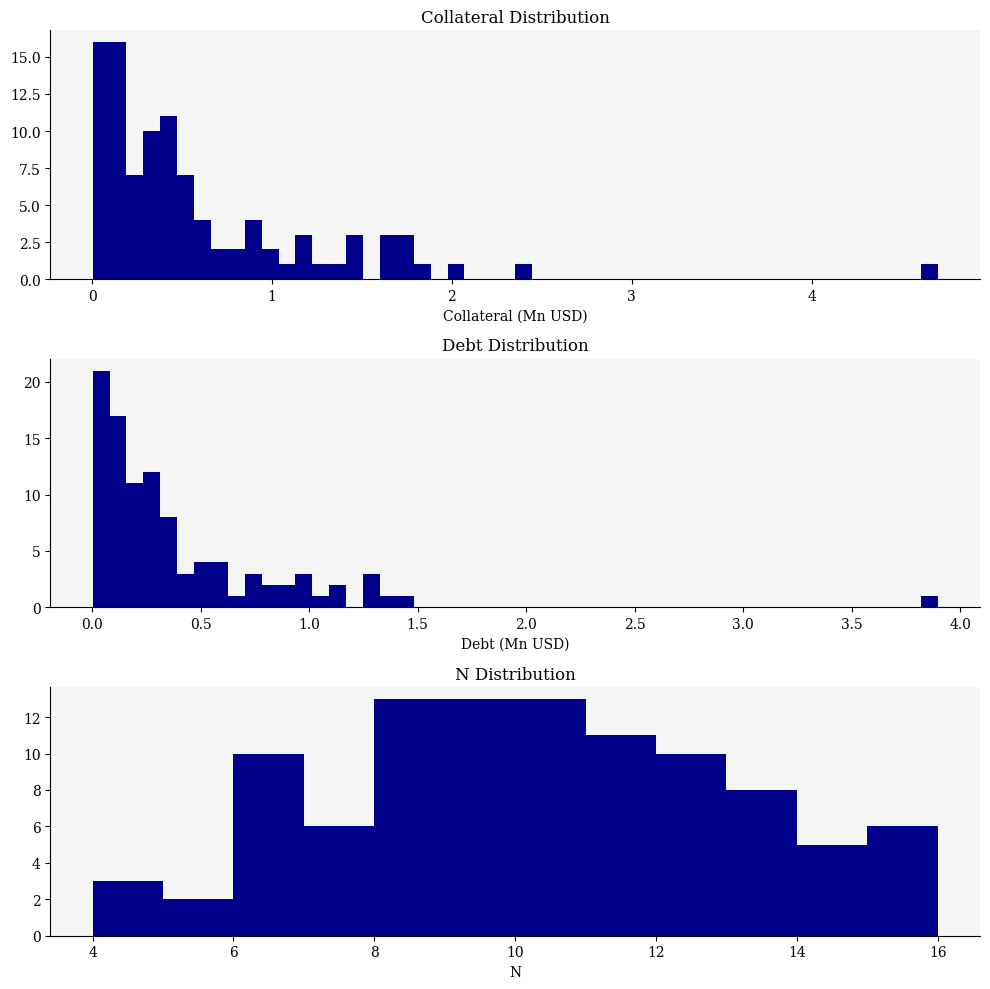

In [5]:
# borrowers = controller.gen_borrowers(N_BORROWERS, COINS, v=True)
# np.save("data/borrowers.npy", borrowers)
borrowers = np.load("data/borrowers.npy")
_plot_borrowers(borrowers, BASE_PRICE)

In [6]:
# TODO Will want other metrics to be satisfied as well: e.g., incorporate LTV, # of bands, and check that it's correct
# Check that this generate func will generally give us ~ the expected debt
debts = []
for _ in range(1000):
    bs = controller.gen_borrowers(N_BORROWERS, COINS)
    debts.append(bs[:,1].sum())
print(f"Mean debt: {round(np.mean(debts) / 1e6)} Mns USD")
print(f"Desired debt: {DEBT / 1e6} Mns USD")

Mean debt: 39 Mns USD
Desired debt: 44.0 Mns USD


Initial system health: 0.3820759394949393


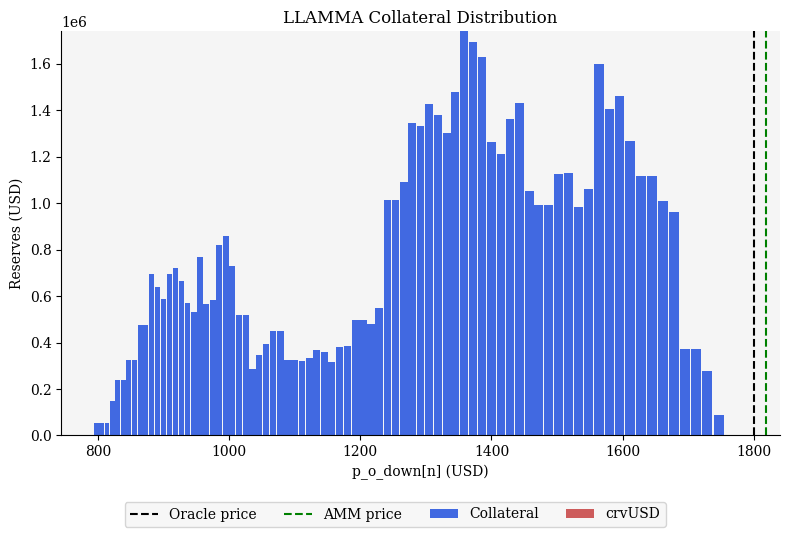

In [7]:
for i, b in enumerate(borrowers):
    # Deposit!
    controller.create_loan(i, *b)
print(f'Initial system health: {controller.system_health}')
llamma.plot_reserves()

## Run Simulation

,timestamp,spot,oracle,liquidation_pnl,arbitrage_pnl,system_health,liquidation_count,arbitrage_count,bad_debt
datetime,,,,,,,,,
2023-10-19 00:26:21,1697675181,1800.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 01:26:21,1697678781,1621.595528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 02:26:21,1697682381,1562.490389,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 03:26:21,1697685981,1529.652174,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 04:26:21,1697689581,1534.929242,0.0,0.0,0.0,0.0,0.0,0.0,0.0


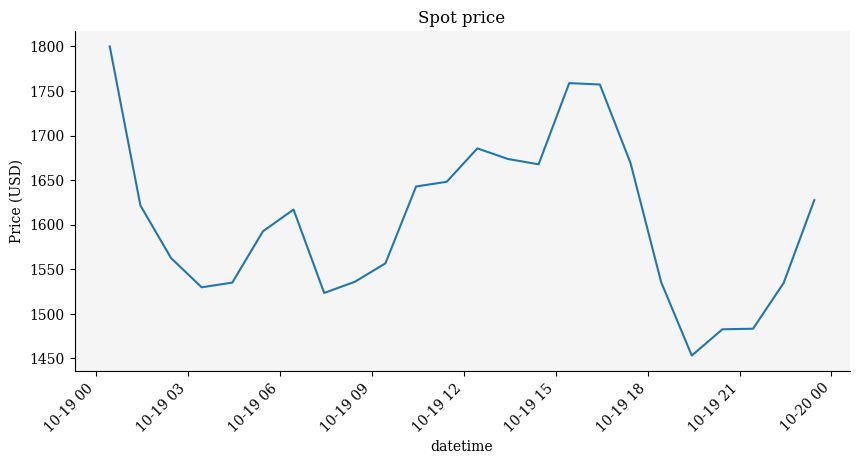

In [8]:
# TODO other metrics: admin_fees, total gains and losses (arb_pnl + liq_pnl + admin_fees)
# TODO pnl is accounting for gas/slippage on external venues, so it's not exactly pnl for the system. 
# Example: +10 pnl for a liquidator might actually be -15 pnl for the system.
# TODO test fees going to users

PERIOD = 86400 # 1 day
WINDOW = 60*60
nobs = PERIOD//WINDOW

def gen_test_df():
    times = [START] + [int(START + dt*WINDOW) for dt in range(1, nobs)]
    df = pd.DataFrame(columns=['timestamp', 'spot', 'oracle', 'liquidation_pnl', 'liquidation_count', 'arbitrage_pnl', 'arbitrage_count', 'system_health', 'bad_debt'])
    df['timestamp'] = times
    df.index = pd.to_datetime(df['timestamp'], unit='s')
    df.index.name = 'datetime'
    df['spot'] = np.concatenate([[BASE_PRICE], gen_gbm(S0=BASE_PRICE,mu=-0.1, sigma=0.2, dt=1/nobs,T=1)[1:]])
    # Caching because I like this price curve for testing
    # df.to_csv('./data/tmp.csv')
    return df

def read_test_df(fn='./data/tmp.csv'):
    df = pd.read_csv(fn, index_col=0)
    df.index = pd.to_datetime(df.index)
    return df

df_user = pd.DataFrame() # to track any user data

df = read_test_df()
df['spot'].plot(rot=45, figsize=(10,5), title='Spot price', ylabel='Price (USD)')
df = df.astype(float)
df['timestamp'] = df['timestamp'].astype(int)
df.head()

In [9]:
# TODO the way we are computing bad debt relies on "health", but we really want to know
# the *actual* bad debt: i.e., the current market value of the stuff in LLAMMA vs outstanding debt
# debt - crvUSD in LLAMMA = true debt
# can true debt be covered by selling all the ETH in LLAMMA?
# should we account for the slippage in how this crvUSD and ETH can be obtained from LLAMMA?
# if so, should this be adiabatically or isntantaneously?
# and should it account for external slippage?
# Basically, how much do I get from liquidating the system rn.

# Init external market liquidity for slippage calc
ext_stable_liquidity = 2e16 # NOTE why 2M?
ext_collat_liquidity = ext_stable_liquidity / BASE_PRICE
ext_swap_fee = 0.005

user = 69 # NOTE user of interest

from src.utils import fn_frames_reserves, fn_gif_reserves

# Run simulation
frame = 0
for i, row in df.iterrows():

    fn = fn_frames_reserves.format(frame)

    print(f'\nNew Step: {i}\n-----------------------\n')
    
    # Update oracle
    ema_price = oracle.update(row['timestamp'], row['spot'])
    df.loc[i, 'oracle'] = ema_price

    # Update external liquidity
    ext_collat_liquidity = ext_stable_liquidity / row['spot']

    # TODO really a liquidator would do whatever is more profitable first

    # Check for arbitrage
    arbitrage_pnl = liquidator.arbitrage(llamma, row['spot'], ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)

    # Track user of interest
    if user in controller.loans:
        df_user.loc[i, 'Debt'] = controller.loans[user]
        df_user.loc[i, 'Health'] = controller.health(user)
        df_user.loc[i, 'Sum x'], df_user.loc[i, 'Sum y'] = llamma.get_sum_xy(user)

    # Check for liquidations
    liquidation_pnl, bad_debt = \
        liquidator.perform_liquidations(controller, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)

    # Track metrics
    df.loc[i, 'liquidation_pnl'] = liquidation_pnl
    df.loc[i, 'liquidation_count'] = liquidator.liquidation_count
    df.loc[i, 'arbitrage_pnl'] = arbitrage_pnl
    df.loc[i, 'arbitrage_count'] = liquidator.arbitrage_count
    df.loc[i, 'system_health'] = controller.system_health
    df.loc[i, 'bad_debt'] = bad_debt

    # For GIF
    llamma.plot_reserves(fn)
    frame += 1

frames = [imageio.v2.imread(fn_frames_reserves.format(i)) for i in range(len(df))]
imageio.mimsave(fn_gif_reserves, frames, fps=FPS)
plot_sim(df)


New Step: 2023-10-19 00:26:21
-----------------------


New Step: 2023-10-19 01:26:21
-----------------------

Performed arbitrage, profit: 256460 USD
Missed liquidation for user 42 with health -0.09778586995929828.
Missed liquidation for user 54 with health -0.11445358141903383.
Missed liquidation for user 66 with health -0.0744214539282575.

New Step: 2023-10-19 02:26:21
-----------------------

Performed arbitrage, profit: 164815 USD
Liquidated user 0 with pnl 83129.58822920552.
Missed liquidation for user 3 with health -0.06280200500722222.
Missed liquidation for user 24 with health -0.06375011848424561.
Missed liquidation for user 28 with health -0.09469119384898061.
Missed liquidation for user 42 with health -0.0977858699593025.
Missed liquidation for user 54 with health -0.11445358141903705.
Missed liquidation for user 66 with health -0.0744214539282605.
Missed liquidation for user 81 with health -0.08944171796742928.
Liquidated user 88 with pnl 53.86788380453527.

New Step: 20

## Tracking Metrics

So far we have seen what the reserves look like over time and what actions the liquidator agent is taking (arbitrage, liquidate). There are two other key metrics:
- System health
- Underwater debt (aka bad debt, missed liquidations)

Let's also observe what these look like. They are all neatly combined into a `combined.gif`.

## Investigating User 69

User 69 gets liquidated when the price increases between 4:30am and 5:30am on October 19th (simulated data). This is counterintuitive; does it mean our simulations are wrong? We track user 69's behavior in the below DataFrame. Notice that when the price increases from 4 to 5am, the user gets "de-liquidated" as their position gets converted back to being fully collateral. However, throughout the 7 timesteps, the user gets soft liquidated/de-liquidated 3 times, resulting in a loss of 30 ETH. Following the final de-liquidation, this puts them below the acceptable margin requirement (health), leading to a hard liquidation.

The problem is clear: LVR leads to hard liquidations. However, losing 30 ETH (approx 3%) of their position due to arbitrage seems extreme. Are we overestimating arbitrageur profits?

The pipeline of: price volatility -> arbitrage -> LVR -> hard liquidations or even missed liquidations seems clear though, we will likely want to investigate.

In [20]:
df_user.join(df[['spot', 'oracle']])

,Debt,Health,Sum x,Sum y,spot,oracle
2023-10-19 00:26:21,1.305477e+06,0.181954,0.000000,940.833034,1800.000000,1800.000000
2023-10-19 01:26:21,1.305477e+06,0.053700,0.000000,940.833034,1621.595528,1622.037748
2023-10-19 02:26:21,1.305477e+06,0.059621,121572.920912,861.941240,1562.490389,1562.637992
2023-10-19 03:26:21,1.305477e+06,0.119627,457764.142397,636.127900,1529.652174,1529.733938
2023-10-19 04:26:21,1.305477e+06,0.418724,457764.142397,636.127900,1534.929242,1534.916364
2023-10-19 05:26:21,1.305477e+06,-0.001492,0.000000,910.893866,1592.491513,1592.348798
